# Goal:
Create a player composite score for every NBA player. This composite score is a weighted sum of several NBA advanced metrics. We will also be clustering players based on this composite score and defining their career success.

Import packages and data

In [1]:
! pip install yellowbrick
import pandas as pd
import numpy as np
import getpass
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, StandardScaler, QuantileTransformer
from scipy.cluster.hierarchy import ward, fcluster, inconsistent, linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(12, 8)})

     |████████████████████████████████| 266kB 1.6MB/s eta 0:00:01


In [2]:
mypasswd = getpass.getpass()
conn = psycopg2.connect(database = 'cs20_group4',
                              user = 'jpcp73',#replace with pawprint
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)
cursor = conn.cursor()

········


Assemble our NBA statistics 

In [3]:
data = pd.read_sql_query("""
SELECT
    nba.player_id
    , nba.player_name
    , nba.season
    , nba.box_plus_minus
    , nba.defensive_box_plus_minus
    , nba.defensive_win_shares
    , nba.minutes_played
    , nba.offensive_win_shares
    , nba.offensive_box_plus_minus
    , nba.player_efficiency_rating
    , nba.value_over_replacement_player as vorp
    , nba.win_shares
    , nba.win_shares_per_48_minutes
    , nba.age
    , min.win_shares_per_minute
FROM nba_player_season_totals nba
JOIN nba_player_per_minute_stats_season min ON nba.player_id = min.player_id
                                                AND nba.season = min.season
WHERE nba.games_played IS NOT NULL
    AND nba.minutes_played IS NOT NULL
""", con = conn)
print(data.shape)
data.head()

(21516, 15)


,player_id,player_name,season,box_plus_minus,defensive_box_plus_minus,defensive_win_shares,minutes_played,offensive_win_shares,offensive_box_plus_minus,player_efficiency_rating,vorp,win_shares,win_shares_per_48_minutes,age,win_shares_per_minute
0,mayfike01,Ken Mayfield,1976.0,-12.2,-6.2,0.0,64.0,-0.2,-6.0,7.3,-0.2,-0.2,-0.134,27.641909,-0.003125
1,willima02,Marvin Williams,2006.0,-3.7,-1.9,0.7,1952.0,2.1,-1.7,12.2,-0.8,2.8,0.069,19.537704,0.001434
2,willima02,Marvin Williams,2007.0,-2.7,-0.7,1.4,2179.0,0.9,-2.0,12.2,-0.4,2.3,0.051,20.537040,0.001056
3,willima02,Marvin Williams,2008.0,-1.6,-0.6,2.1,2765.0,3.6,-1.0,14.5,0.3,5.7,0.099,21.536377,0.002061
4,willima02,Marvin Williams,2009.0,0.9,0.1,2.2,2093.0,3.9,0.8,16.0,1.5,6.1,0.140,22.538450,0.002914


Inspect columns and single out those we'll want to use in our final composite score. We are focusing here on advanced, catch-all metrics that attempt to describe a player's overall quality.

In [4]:
data.columns

Index(['player_id', 'player_name', 'season', 'box_plus_minus',
       'defensive_box_plus_minus', 'defensive_win_shares', 'minutes_played',
       'offensive_win_shares', 'offensive_box_plus_minus',
       'player_efficiency_rating', 'vorp', 'win_shares',
       'win_shares_per_48_minutes', 'age', 'win_shares_per_minute'],
      dtype='object')

In [5]:
adv_metrics = ['box_plus_minus', 'defensive_box_plus_minus', 'defensive_win_shares',
              'offensive_box_plus_minus', 'offensive_win_shares', 'defensive_box_plus_minus', 
              'player_efficiency_rating', 'vorp', 'win_shares', 'win_shares_per_minute']

In [6]:
df = data[['player_id', 'player_name', 'minutes_played', 'age'] + adv_metrics]
df.head()

,player_id,player_name,minutes_played,age,box_plus_minus,defensive_box_plus_minus,defensive_win_shares,offensive_box_plus_minus,offensive_win_shares,defensive_box_plus_minus,player_efficiency_rating,vorp,win_shares,win_shares_per_minute
0,mayfike01,Ken Mayfield,64.0,27.641909,-12.2,-6.2,0.0,-6.0,-0.2,-6.2,7.3,-0.2,-0.2,-0.003125
1,willima02,Marvin Williams,1952.0,19.537704,-3.7,-1.9,0.7,-1.7,2.1,-1.9,12.2,-0.8,2.8,0.001434
2,willima02,Marvin Williams,2179.0,20.537040,-2.7,-0.7,1.4,-2.0,0.9,-0.7,12.2,-0.4,2.3,0.001056
3,willima02,Marvin Williams,2765.0,21.536377,-1.6,-0.6,2.1,-1.0,3.6,-0.6,14.5,0.3,5.7,0.002061
4,willima02,Marvin Williams,2093.0,22.538450,0.9,0.1,2.2,0.8,3.9,0.1,16.0,1.5,6.1,0.002914


Check for prevalence of null values

In [7]:
df.isnull().sum() / len(df)

player_id                   0.000000
player_name                 0.000000
minutes_played              0.000000
age                         0.000000
box_plus_minus              0.146542
defensive_box_plus_minus    0.146542
defensive_win_shares        0.001441
offensive_box_plus_minus    0.146542
offensive_win_shares        0.001441
defensive_box_plus_minus    0.146542
player_efficiency_rating    0.001580
vorp                        0.146542
win_shares                  0.001441
win_shares_per_minute       0.001534
dtype: float64

We need to filter our data to both remove nulls and impose a minimum number of minutes played so as to reduce the effects of outliers.

In [8]:
df = df.loc[df.minutes_played >= 100].dropna()
print(df.shape)
df.head()

(16631, 14)


,player_id,player_name,minutes_played,age,box_plus_minus,defensive_box_plus_minus,defensive_win_shares,offensive_box_plus_minus,offensive_win_shares,defensive_box_plus_minus,player_efficiency_rating,vorp,win_shares,win_shares_per_minute
1,willima02,Marvin Williams,1952.0,19.537704,-3.7,-1.9,0.7,-1.7,2.1,-1.9,12.2,-0.8,2.8,0.001434
2,willima02,Marvin Williams,2179.0,20.537040,-2.7,-0.7,1.4,-2.0,0.9,-0.7,12.2,-0.4,2.3,0.001056
3,willima02,Marvin Williams,2765.0,21.536377,-1.6,-0.6,2.1,-1.0,3.6,-0.6,14.5,0.3,5.7,0.002061
4,willima02,Marvin Williams,2093.0,22.538450,0.9,0.1,2.2,0.8,3.9,0.1,16.0,1.5,6.1,0.002914
5,willima02,Marvin Williams,2468.0,23.537787,-0.2,0.4,2.6,-0.5,3.1,0.4,13.0,1.1,5.7,0.002310


Reshape each of the advanced metrics in our dataset to a uniform 0 to 1 distribution. We want each of these metrics on the same scale so it's easier to compare to one another.

In [9]:
qt = QuantileTransformer()

In [10]:
df[['defensive_box_plus_minus', 'defensive_win_shares', 'offensive_box_plus_minus',
    'offensive_win_shares', 'player_efficiency_rating', 'vorp']] = qt.fit_transform(df[['defensive_box_plus_minus', 'defensive_win_shares', 
                                                                                        'offensive_box_plus_minus', 'offensive_win_shares', 
                                                                                        'player_efficiency_rating', 'vorp']])
df.head()

,player_id,player_name,minutes_played,age,box_plus_minus,defensive_box_plus_minus,defensive_win_shares,offensive_box_plus_minus,offensive_win_shares,defensive_box_plus_minus,player_efficiency_rating,vorp,win_shares,win_shares_per_minute
1,willima02,Marvin Williams,1952.0,19.537704,-3.7,0.159660,0.325325,0.397898,0.699700,0.159660,0.393393,0.031532,2.8,0.001434
2,willima02,Marvin Williams,2179.0,20.537040,-2.7,0.410911,0.566567,0.351351,0.499499,0.410911,0.393393,0.124625,2.3,0.001056
3,willima02,Marvin Williams,2765.0,21.536377,-1.6,0.433433,0.737237,0.511512,0.843343,0.433433,0.622122,0.535536,5.7,0.002061
4,willima02,Marvin Williams,2093.0,22.538450,0.9,0.597598,0.757257,0.776777,0.863864,0.597598,0.752252,0.778779,6.1,0.002914
5,willima02,Marvin Williams,2468.0,23.537787,-0.2,0.662162,0.824825,0.589590,0.806807,0.662162,0.473974,0.719219,5.7,0.002310


Filter for only the columns we'll be using in the creation of the composite score.

In [11]:
df = df[['player_id', 'player_name', 'age', 'box_plus_minus',
         'win_shares', 'player_efficiency_rating', 'vorp']]
df.head()

,player_id,player_name,age,box_plus_minus,win_shares,player_efficiency_rating,vorp
1,willima02,Marvin Williams,19.537704,-3.7,2.8,0.393393,0.031532
2,willima02,Marvin Williams,20.537040,-2.7,2.3,0.393393,0.124625
3,willima02,Marvin Williams,21.536377,-1.6,5.7,0.622122,0.535536
4,willima02,Marvin Williams,22.538450,0.9,6.1,0.752252,0.778779
5,willima02,Marvin Williams,23.537787,-0.2,5.7,0.473974,0.719219


Initial composite score will be the summed values of our advanced metrics for a given season for a given player.

In [12]:
df['composite_score'] = df.drop(['player_id', 'player_name', 'age'],
                               axis = 1).sum(axis = 1)

In [13]:
df.head()

,player_id,player_name,age,box_plus_minus,win_shares,player_efficiency_rating,vorp,composite_score
1,willima02,Marvin Williams,19.537704,-3.7,2.8,0.393393,0.031532,-0.475075
2,willima02,Marvin Williams,20.537040,-2.7,2.3,0.393393,0.124625,0.118018
3,willima02,Marvin Williams,21.536377,-1.6,5.7,0.622122,0.535536,5.257658
4,willima02,Marvin Williams,22.538450,0.9,6.1,0.752252,0.778779,8.531031
5,willima02,Marvin Williams,23.537787,-0.2,5.7,0.473974,0.719219,6.693193


Again, reshape this composite score to a 0 to 1 uniform distribution.

In [14]:
df.composite_score = qt.fit_transform(np.array(df.composite_score).reshape(-1, 1))

In [15]:
df[['player_id', 'player_name', 'age', 'composite_score']]

,player_id,player_name,age,composite_score
1,willima02,Marvin Williams,19.537704,0.336435
2,willima02,Marvin Williams,20.537040,0.374408
3,willima02,Marvin Williams,21.536377,0.684688
4,willima02,Marvin Williams,22.538450,0.821649
5,willima02,Marvin Williams,23.537787,0.750035
...,...,...,...,...
21511,burleto01,Tom Burleson,24.854720,0.736738
21512,burleto01,Tom Burleson,25.854056,0.792999
21513,burleto01,Tom Burleson,26.853392,0.597875
21514,burleto01,Tom Burleson,27.852728,0.095868


Check out some of the best individual seasons in our dataset. These names largely align with who we would expect to see.

In [16]:
df[['player_id', 'player_name', 'age', 'composite_score']].sort_values(by = 'composite_score',
                                                                       ascending = False).head(50)

,player_id,player_name,age,composite_score
13001,jordami01,Michael Jordan,24.871147,1.000000
9815,jamesle01,LeBron James,24.005969,0.999983
13002,jordami01,Michael Jordan,25.873221,0.999825
13004,jordami01,Michael Jordan,27.871893,0.999598
9816,jamesle01,LeBron James,25.005305,0.999580
9820,jamesle01,LeBron James,28.006051,0.999563
17488,robinda01,David Robinson,28.405785,0.999563
12032,curryst01,Stephen Curry,27.800708,0.999475
13003,jordami01,Michael Jordan,26.872557,0.999336
18927,paulch01,Chris Paul,23.658254,0.999318


To avoid punishing players who play for an exceptionally long time, we've chosen to only capture a player's 12 (or fewer) best seasons when assessing the quality of their career.

In [17]:
df = df.groupby(['player_id', 'player_name']).apply(lambda x: x.nlargest(12, columns = 'composite_score')).reset_index(drop = True)
print(df.shape)
df.head()

(15796, 8)


,player_id,player_name,age,box_plus_minus,win_shares,player_efficiency_rating,vorp,composite_score
0,abdelal01,Alaa Abdelnaby,23.521359,-3.9,2.1,0.524525,0.089089,0.290859
1,abdelal01,Alaa Abdelnaby,24.523433,-4.2,2.0,0.494995,0.045546,0.261650
2,abdelal01,Alaa Abdelnaby,22.522023,-5.0,0.5,0.484484,0.243243,0.138197
3,abdelal01,Alaa Abdelnaby,26.522105,-6.3,0.3,0.434434,0.064064,0.070652
4,abdelal01,Alaa Abdelnaby,25.522769,-10.2,-0.1,0.148148,0.175175,0.004719


Now that we're down to the dozen best seasons for each player, we can group by player id to assess each player's overall quality.

In [18]:
player = df.groupby(['player_id', 'player_name']).agg({'player_name' : 'count',
                                                       'composite_score' : ['sum', 'max']}).rename({'player_name' : 'seasons'},
                                                                                                   axis = 1).reset_index()
player.columns = ['_'.join(x) for x in player.columns]
player.rename({'player_id_' : 'player_id',
               'player_name_' : 'player_name',
               'seasons_count' : 'seasons',
               'composite_score_sum' : 'composite_score',
               'composite_score_max' : 'peak'}, axis = 1, inplace = True)
player.head()

,player_id,player_name,seasons,composite_score,peak
0,abdelal01,Alaa Abdelnaby,5,0.766077,0.290859
1,abdulka01,Kareem Abdul-Jabbar,12,11.855574,0.999160
2,abdulma01,Walt Hazzard,1,0.245846,0.245846
3,abdulma02,Mahmoud Abdul-Rauf,9,3.738280,0.812596
4,abdulta01,Tariq Abdul-Wahad,6,1.521443,0.481481


We have created an adjusted composite score to account for players who did not (or have not) play in the NBA for very long. We essentially add two seasons worth of average performance to each player's career. This has the effect of pulling players with few observances back toward the mean. We then transform this adjusted composite to another 0 to 1 uniform distribution.

In [19]:
player['composite_adjusted'] = player.composite_score / player.seasons
player.composite_adjusted = qt.fit_transform(np.array(player.composite_adjusted).reshape(-1, 1))

In [20]:
player.head()

,player_id,player_name,seasons,composite_score,peak,composite_adjusted
0,abdelal01,Alaa Abdelnaby,5,0.766077,0.290859,0.215476
1,abdulka01,Kareem Abdul-Jabbar,12,11.855574,0.999160,0.997993
2,abdulma01,Walt Hazzard,1,0.245846,0.245846,0.349375
3,abdulma02,Mahmoud Abdul-Rauf,9,3.738280,0.812596,0.575879
4,abdulta01,Tariq Abdul-Wahad,6,1.521443,0.481481,0.360382


Check out the best players in our dataset by this adjusted composite metric.

In [21]:
player.sort_values(by = 'composite_adjusted',
                  ascending = False).head(25)

,player_id,player_name,seasons,composite_score,peak,composite_adjusted
1272,jamesle01,LeBron James,12,11.967337,0.999983,1.000000
1619,malonka01,Karl Malone,12,11.923879,0.997411,0.999552
2186,robinda01,David Robinson,12,11.881984,0.999563,0.999120
147,barklch01,Charles Barkley,12,11.869191,0.998695,0.998927
1998,paulch01,Chris Paul,12,11.867694,0.999318,0.998822
1334,johnsma02,Magic Johnson,12,11.857506,0.998117,0.998111
1,abdulka01,Kareem Abdul-Jabbar,12,11.855574,0.999160,0.997993
722,duncati01,Tim Duncan,12,11.831516,0.997614,0.997579
1392,jordami01,Michael Jordan,12,11.814787,1.000000,0.997291
1953,onealsh01,Shaquille O'Neal,12,11.792240,0.999108,0.996823


Let's look at the distribution of the adjusted composite score.

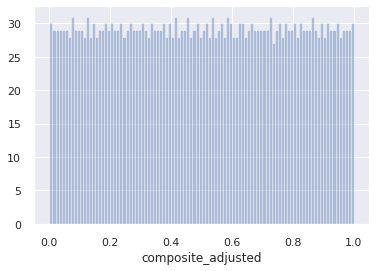

In [22]:
sns.distplot(player.composite_adjusted,
            bins = 100,
            kde = False);

Let's look at the distribution of the best composite scores for each NBA player.

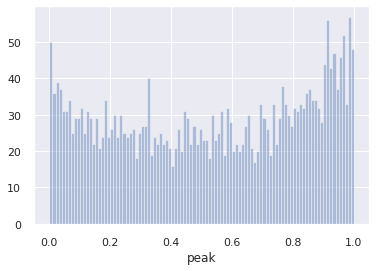

In [23]:
sns.distplot(player.peak,
            bins = 100,
            kde = False);

Examine the relationship between the summed composite score and the averaged adjusted composite. There looks to be an exponential increase in composite score as the adjusted composite increases.

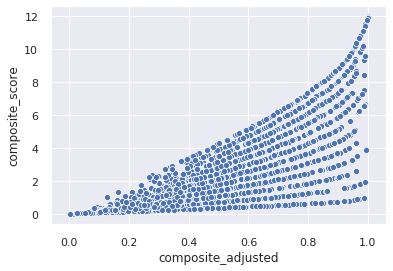

In [24]:
sns.scatterplot(player.composite_adjusted,
               player.composite_score);

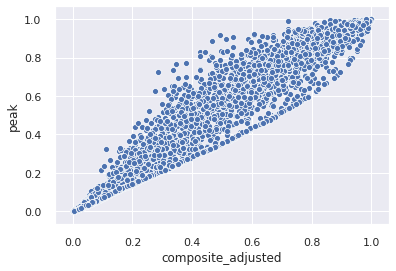

In [25]:
sns.scatterplot(player.composite_adjusted,
               player.peak);

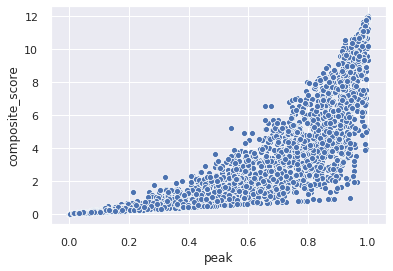

In [26]:
sns.scatterplot(player.peak,
               player.composite_score);

We ultimately want to break these careers down into separate categories, so we are again using KMeans to help us draw boundaries between the various types of careers.

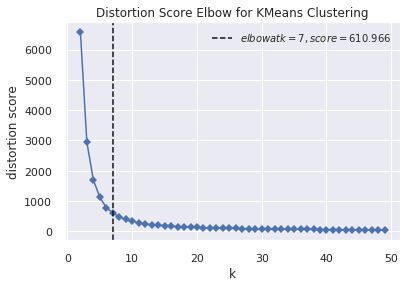

In [27]:
km = KMeans(random_state = 0)
elbow = KElbowVisualizer(km, k = (2, 50), timings = False)
elbow.fit(np.array(player[['composite_score', 'composite_adjusted', 'peak']]))
elbow.poof();

In [28]:
kmeans = KMeans(n_clusters = elbow.elbow_value_, random_state = 0)
player['cluster'] = kmeans.fit_predict(np.array(player[['composite_score', 'composite_adjusted', 'peak']]))
player.head()

,player_id,player_name,seasons,composite_score,peak,composite_adjusted,cluster
0,abdelal01,Alaa Abdelnaby,5,0.766077,0.290859,0.215476,0
1,abdulka01,Kareem Abdul-Jabbar,12,11.855574,0.999160,0.997993,4
2,abdulma01,Walt Hazzard,1,0.245846,0.245846,0.349375,0
3,abdulma02,Mahmoud Abdul-Rauf,9,3.738280,0.812596,0.575879,5
4,abdulta01,Tariq Abdul-Wahad,6,1.521443,0.481481,0.360382,3


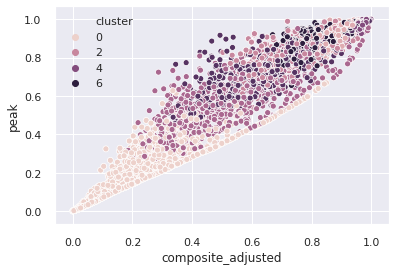

In [29]:
sns.scatterplot(player.composite_adjusted,
               player.peak,
               hue = player.cluster);

Examine the differences in quality for each cluster. Then assign an arbitrary categorization to each player in each cluster.

In [30]:
player.groupby(['cluster']).agg({'player_id' : 'nunique',
                                 'seasons' : 'mean',
                                 'composite_score' : 'mean',
                                'composite_adjusted' : 'mean',
                                'peak' : 'mean'}).reset_index().sort_values(by = 'cluster')

,cluster,player_id,seasons,composite_score,composite_adjusted,peak
0,0,1186,1.844857,0.299348,0.233983,0.209451
1,1,169,11.763314,8.589497,0.893341,0.928340
2,2,271,9.365314,4.916569,0.719114,0.814267
3,3,559,4.372093,1.484615,0.527044,0.568474
4,4,122,11.975410,10.740793,0.972721,0.975481
5,5,393,7.328244,3.142971,0.621282,0.722717
6,6,217,10.585253,6.706210,0.818889,0.888717


Print out an example player in each player career success cluster.

In [31]:
for c in player['cluster'].sort_values().unique():
    print(c)
    subset = player.loc[player.cluster == c].copy()
    print(subset.sample(n = 1).player_name.values)
    print('-' * 10)

0
['Brandon Hunter']
----------
1
['Elden Campbell']
----------
2
['Kwame Brown']
----------
3
['Henry Sims']
----------
4
['David West']
----------
5
['Tyrus Thomas']
----------
6
['Ray Williams']
----------


Defin the career cluster numeric label dictionary to convert into realized meanings.

In [32]:
clusters_dict = {0 : 'Fringe NBA player',
                1 : 'Star',
                2 : 'Sixth Man',
                3 : 'Benchwarmer',
                4 : 'Superstar',
                5 : 'Role Player',
                6 : 'Starter'}

In [33]:
player['role'] = None
for c in player.cluster.unique():
    player.loc[player.cluster == c, 'role'] = clusters_dict[c]

In [34]:
player.sample(n = 10)

,player_id,player_name,seasons,composite_score,peak,composite_adjusted,cluster,role
634,davisri01,Ricky Davis,11,5.380612,0.809504,0.673799,2,Sixth Man
2384,smithke03,Keith Smith,1,0.098863,0.098863,0.137243,0,Fringe NBA player
1399,kaminfr01,Frank Kaminsky,4,2.171589,0.611969,0.728624,3,Benchwarmer
2512,thabeha01,Hasheem Thabeet,5,1.431696,0.613614,0.404450,3,Benchwarmer
229,biyombi01,Bismack Biyombo,8,3.833080,0.769021,0.661201,5,Role Player
1895,newbiiv01,Ivano Newbill,3,0.585653,0.294978,0.277615,0,Fringe NBA player
2265,sandeme01,Melvin Sanders,1,0.155928,0.155928,0.219766,0,Fringe NBA player
2812,willike02,Kevin Willis,12,8.037557,0.930011,0.851560,1,Star
415,calvima01,Mack Calvin,7,3.213186,0.912494,0.636916,5,Role Player
2089,profila01,Laron Profit,4,0.739304,0.311541,0.260992,0,Fringe NBA player


Define our table schema for the `nba_player_roles` table.

In [35]:
cursor = conn.cursor()
create_table = """
DROP TABLE IF EXISTS nba_player_roles;
CREATE TABLE nba_player_roles(
player_id VARCHAR(100)
, player_name VARCHAR(250)
, seasons numeric
, composite_score numeric
, peak numeric
, composite_adjusted numeric
, cluster numeric
, role VARCHAR(50)
)
"""
cursor.execute(create_table)
conn.commit()

Insert data into the `nba_player_roles` table

In [36]:
final = player.where(pd.notnull(player), None)

INSERT_SQL = "INSERT INTO nba_player_roles"
INSERT_SQL += "(player_id"
INSERT_SQL += ", player_name"
INSERT_SQL += ", seasons"
INSERT_SQL += ", composite_score"
INSERT_SQL += ", peak"
INSERT_SQL += ", composite_adjusted"
INSERT_SQL += ", cluster"
INSERT_SQL += ", role) VALUES"
INSERT_SQL += "(%s, %s, %s, %s, %s, %s, %s, %s)"

with conn, conn.cursor() as cursor:
    for row in final.itertuples(index=False, name=None):
        cursor.execute(INSERT_SQL,row)

Test that our new table has been created successfully and that the data has been inserted.

In [37]:
test = pd.read_sql_query("""
SELECT
    *
FROM nba_player_roles r
LIMIT 10
""", con = conn)
test

,player_id,player_name,seasons,composite_score,peak,composite_adjusted,cluster,role
0,abdelal01,Alaa Abdelnaby,5.0,0.766077,0.290859,0.215476,0.0,Fringe NBA player
1,abdulka01,Kareem Abdul-Jabbar,12.0,11.855574,0.999160,0.997993,4.0,Superstar
2,abdulma01,Walt Hazzard,1.0,0.245846,0.245846,0.349375,0.0,Fringe NBA player
3,abdulma02,Mahmoud Abdul-Rauf,9.0,3.738280,0.812596,0.575879,5.0,Role Player
4,abdulta01,Tariq Abdul-Wahad,6.0,1.521443,0.481481,0.360382,3.0,Benchwarmer
5,abdulza01,Zaid Abdul-Aziz,5.0,2.242962,0.839855,0.621557,3.0,Benchwarmer
6,abdursh01,Shareef Abdur-Rahim,11.0,8.803302,0.932771,0.939451,1.0,Star
7,abernto01,Tom Abernethy,5.0,2.718750,0.765627,0.729836,5.0,Role Player
8,abrinal01,Álex Abrines,3.0,0.981798,0.397787,0.470040,3.0,Benchwarmer
9,ackeral01,Alex Acker,1.0,0.069729,0.069729,0.100326,0.0,Fringe NBA player
